In [73]:
import csv

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

tf.device('/gpu:0')
RANDOM_SEED = 42

# Specify each path

In [74]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [75]:
NUM_CLASSES = 6

# Dataset reading

In [76]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [77]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [79]:
X_dataset_check = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(0, (21 * 2) + 1)))
b = pd.DataFrame(X_dataset_check)
print(b)

        0    1    2         3         4         5         6         7   \
0      0.0  0.0  0.0 -0.122378 -0.108392 -0.227273 -0.307692 -0.171329   
1      0.0  0.0  0.0 -0.125436 -0.097561 -0.233449 -0.292683 -0.177700   
2      0.0  0.0  0.0 -0.122378 -0.101399 -0.227273 -0.293706 -0.174825   
3      0.0  0.0  0.0 -0.125874 -0.090909 -0.230769 -0.283217 -0.178322   
4      0.0  0.0  0.0 -0.125874 -0.087413 -0.237762 -0.283217 -0.181818   
...    ...  ...  ...       ...       ...       ...       ...       ...   
20235  5.0  0.0  0.0 -0.198830 -0.029240 -0.397661 -0.087719 -0.573099   
20236  5.0  0.0  0.0 -0.198830 -0.029240 -0.403509 -0.087719 -0.573099   
20237  5.0  0.0  0.0 -0.201183 -0.029586 -0.402367 -0.082840 -0.573964   
20238  5.0  0.0  0.0 -0.177665 -0.081218 -0.350254 -0.203046 -0.492386   
20239  5.0  0.0  0.0 -0.161765 -0.093137 -0.313726 -0.240196 -0.431373   

             8         9   ...        33        34        35        36  \
0     -0.468531 -0.027972  ... -0.003

In [80]:
b.groupby(0).size()


0
0.0    4697
1.0    3166
2.0    2837
3.0    2931
4.0    3257
5.0    3352
dtype: int64

# Model building

In [81]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [82]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False) # automatically save your model
# verbose : gọi lại thông báo mỗi khi thông báo
# save_weights_only: lưu lại cả mô hình lẫn thông số mô hình nếu False

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
# dừng quá trình đào tạo nếu hiệu suất mô hình ko đc cải thiện

In [84]:
# Model compilation
model.compile(
    optimizer='adam', # hàm tối ưu
    loss='sparse_categorical_crossentropy', # hàm mất mát
    metrics=['accuracy'] # thuước  đo đánh giá
)

# Model training

In [85]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
119/119 [==============================] - ETA: 0s - loss: 1.7685 - accuracy: 0.2160
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
119/119 [==============================] - 2s 9ms/step - loss: 1.7685 - accuracy: 0.2160 - val_loss: 1.6144 - val_accuracy: 0.4504
Epoch 2/1000
103/119 [========================>.....] - ETA: 0s - loss: 1.5893 - accuracy: 0.3463
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
119/119 [==============================] - 0s 3ms/step - loss: 1.5776 - accuracy: 0.3507 - val_loss: 1.2893 - val_accuracy: 0.6132
Epoch 3/1000
105/119 [=========================>....] - ETA: 0s - loss: 1.4185 - accuracy: 0.4078
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
119/119 [==============================] - 0s 2ms/step - loss: 1.4147 - accuracy: 0.4088 - val_loss: 1.0766 - val_accuracy: 0.7219
Epoch 4/1000
109/119 [==========================>...] - ETA: 0s - loss: 1.3355 - accu

In [86]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

40/40 [==============================] - 0s 1ms/step - loss: 0.6332 - accuracy: 0.8265


In [87]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [88]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 83ms/step
[8.2965270e-03 6.6764331e-01 1.5971331e-02 1.5102557e-04 3.0642378e-01
 1.5139814e-03]
1


# Confusion matrix

159/159 [==============================] - 0s 860us/step


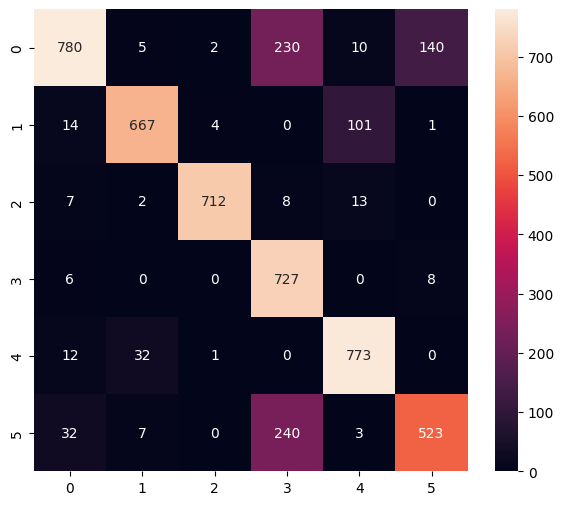

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.67      0.77      1167
           1       0.94      0.85      0.89       787
           2       0.99      0.96      0.97       742
           3       0.60      0.98      0.75       741
           4       0.86      0.94      0.90       818
           5       0.78      0.65      0.71       805

    accuracy                           0.83      5060
   macro avg       0.85      0.84      0.83      5060
weighted avg       0.85      0.83      0.83      5060



In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [90]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [91]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpe0lyiicv\assets


INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpe0lyiicv\assets


6684

# Inference test

In [92]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [93]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [94]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [95]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 998 µs


In [96]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.2965158e-03 6.6764337e-01 1.5971325e-02 1.5102544e-04 3.0642372e-01
 1.5139814e-03]
1
